In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier,XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from imblearn.combine import SMOTETomek
from lazypredict.Supervised import LazyClassifier,LazyRegressor
from sklearn.metrics import classification_report,plot_confusion_matrix,plot_roc_curve,plot_precision_recall_curve

C:\Users\rohit\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
ds_train = pd.read_csv("train.csv")
ds_test = pd.read_csv("test.csv")

In [3]:
ds_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,nan,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,nan,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [4]:
ds_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,100000,3,"Holliday, Daniel",male,19.00,0,0,24745,63.01,NaN,S
1,100001,3,"Nguyen, Lorraine",female,53.00,0,0,13264,5.81,NaN,S
2,100002,1,"Harris, Heather",female,19.00,0,0,25990,38.91,B15315,C
3,100003,2,"Larsen, Eric",male,25.00,0,0,314011,12.93,NaN,S
4,100004,1,"Cleary, Sarah",female,17.00,0,2,26203,26.89,B22515,C


In [5]:
print(ds_train.shape)
print(ds_test.shape)

(100000, 12)
(100000, 11)


##### Shifitng the target column "Survived" at last in train.csv

In [6]:
target = ds_train["Survived"]
ds_train.drop(columns="Survived",axis=1,inplace=True)
ds_train["Survived"] = target
ds_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,0,1,"Oconnor, Frankie",male,nan,2,0,209245,27.14,C12239,S,1
1,1,3,"Bryan, Drew",male,nan,0,0,27323,13.35,NaN,S,0
2,2,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S,0
3,3,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S,0
4,4,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S,1


### Null Values

In [7]:
def null_values(dataset):
    for keys, values in dict(dataset.isna().sum()).items():
        if values!=0:
            print(keys,values)

In [8]:
null_values(ds_train) #Null values in training dataset

Age 3292
Ticket 4623
Fare 134
Cabin 67866
Embarked 250


In [9]:
null_values(ds_test) #Null values in testing dataset

Age 3487
Ticket 5181
Fare 133
Cabin 70831
Embarked 277


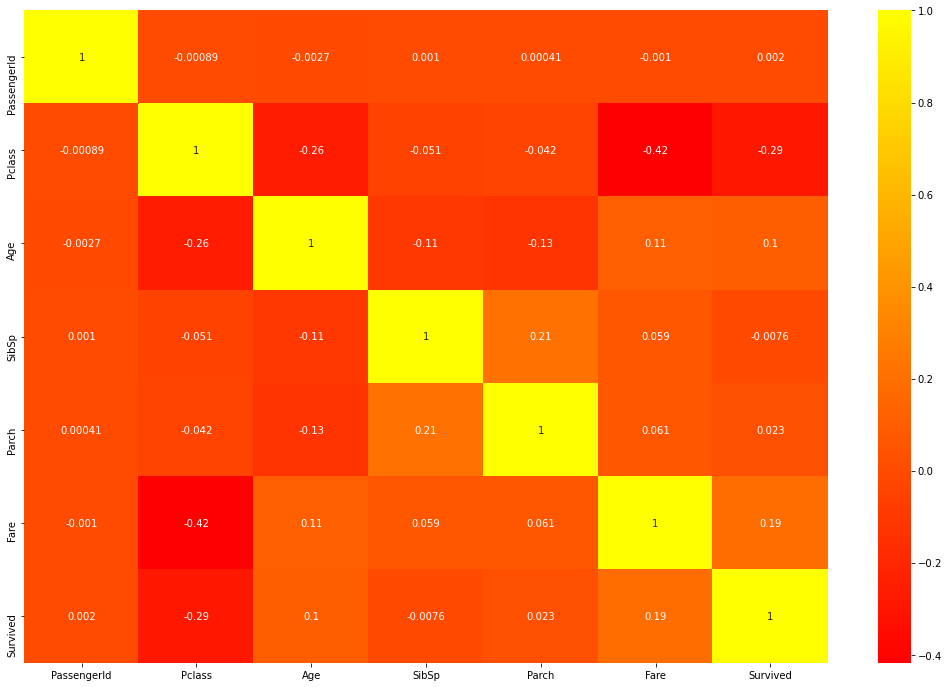

In [10]:
plt.figure(figsize=(18,12))
sns.heatmap(ds_train.corr(),annot=True,cmap="autumn")
plt.show()

In [11]:
ds_train.drop(columns=["PassengerId","Cabin","Name","Ticket"], axis=1, inplace=True)
ds_test.drop(columns=["PassengerId","Cabin","Name","Ticket"], axis=1, inplace=True)

In [12]:
ds_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,male,nan,2,0,27.14,S,1
1,3,male,nan,0,0,13.35,S,0
2,3,male,0.33,1,2,71.29,S,0
3,3,male,19.00,0,0,13.04,S,0
4,3,male,25.00,0,0,7.76,S,1
...,...,...,...,...,...,...,...,...
99995,2,female,62.00,0,0,14.86,C,1
99996,2,male,66.00,0,0,11.15,S,0
99997,3,male,37.00,0,0,9.95,S,0
99998,3,male,51.00,0,1,30.92,S,0


In [13]:
ds_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Pclass    100000 non-null  int64  
 1   Sex       100000 non-null  object 
 2   Age       96708 non-null   float64
 3   SibSp     100000 non-null  int64  
 4   Parch     100000 non-null  int64  
 5   Fare      99866 non-null   float64
 6   Embarked  99750 non-null   object 
 7   Survived  100000 non-null  int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 6.1+ MB


In [14]:
null_values(ds_train)

Age 3292
Fare 134
Embarked 250


In [15]:
null_values(ds_test)

Age 3487
Fare 133
Embarked 277


In [16]:
ds_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,male,nan,2,0,27.14,S,1
1,3,male,nan,0,0,13.35,S,0
2,3,male,0.33,1,2,71.29,S,0
3,3,male,19.00,0,0,13.04,S,0
4,3,male,25.00,0,0,7.76,S,1
...,...,...,...,...,...,...,...,...
99995,2,female,62.00,0,0,14.86,C,1
99996,2,male,66.00,0,0,11.15,S,0
99997,3,male,37.00,0,0,9.95,S,0
99998,3,male,51.00,0,1,30.92,S,0


In [17]:
ds_train["Age"].value_counts()

25.00    2354
23.00    2345
26.00    2320
24.00    2298
27.00    2088
         ... 
69.50       1
87.00       1
74.50       1
78.50       1
80.50       1
Name: Age, Length: 173, dtype: int64

In [18]:
ds_train["Embarked"].value_counts()

S    72139
C    22187
Q     5424
Name: Embarked, dtype: int64

In [19]:
ds_train["Fare"].value_counts()

9.27      87
9.85      87
9.79      86
9.20      85
9.45      83
          ..
116.37     1
92.61      1
234.53     1
167.70     1
241.34     1
Name: Fare, Length: 15935, dtype: int64

### Handling the null values in Embarked Column

In [20]:
Embarked = ds_train.filter(['Pclass','Sex','SibSp','Parch','Embarked'], axis=1)

In [21]:
Embarked

,Pclass,Sex,SibSp,Parch,Embarked
0,1,male,2,0,S
1,3,male,0,0,S
2,3,male,1,2,S
3,3,male,0,0,S
4,3,male,0,0,S
...,...,...,...,...,...
99995,2,female,0,0,C
99996,2,male,0,0,S
99997,3,male,0,0,S
99998,3,male,0,1,S


In [22]:
Embarked_train = Embarked.dropna()

In [23]:
Embarked_train

,Pclass,Sex,SibSp,Parch,Embarked
0,1,male,2,0,S
1,3,male,0,0,S
2,3,male,1,2,S
3,3,male,0,0,S
4,3,male,0,0,S
...,...,...,...,...,...
99995,2,female,0,0,C
99996,2,male,0,0,S
99997,3,male,0,0,S
99998,3,male,0,1,S


In [24]:
ds_train["Embarked"].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [25]:
Embarked_test = Embarked[Embarked["Embarked"].isna()]

In [26]:
Embarked_test

,Pclass,Sex,SibSp,Parch,Embarked
122,2,male,0,0,NaN
266,3,male,0,0,NaN
489,1,female,0,0,NaN
1017,1,female,0,0,NaN
2005,1,female,0,0,NaN
...,...,...,...,...,...
98228,3,male,0,0,NaN
98577,3,female,0,1,NaN
98873,1,female,2,1,NaN
99237,3,female,0,0,NaN


In [27]:
Embarked_test.drop(columns="Embarked",axis=1,inplace=True)

In [28]:
Embarked_test

,Pclass,Sex,SibSp,Parch
122,2,male,0,0
266,3,male,0,0
489,1,female,0,0
1017,1,female,0,0
2005,1,female,0,0
...,...,...,...,...
98228,3,male,0,0
98577,3,female,0,1
98873,1,female,2,1
99237,3,female,0,0


In [29]:
enc_LE = LabelEncoder()

In [30]:
Embarked_train.iloc[:,-1] = enc_LE.fit_transform(Embarked_train.iloc[:,-1])

In [31]:
Embarked_train

,Pclass,Sex,SibSp,Parch,Embarked
0,1,male,2,0,2
1,3,male,0,0,2
2,3,male,1,2,2
3,3,male,0,0,2
4,3,male,0,0,2
...,...,...,...,...,...
99995,2,female,0,0,0
99996,2,male,0,0,2
99997,3,male,0,0,2
99998,3,male,0,1,2


In [32]:
Embarked_train = pd.get_dummies(Embarked_train)
Embarked_train

,Pclass,SibSp,Parch,Embarked,Sex_female,Sex_male
0,1,2,0,2,0,1
1,3,0,0,2,0,1
2,3,1,2,2,0,1
3,3,0,0,2,0,1
4,3,0,0,2,0,1
...,...,...,...,...,...,...
99995,2,0,0,0,1,0
99996,2,0,0,2,0,1
99997,3,0,0,2,0,1
99998,3,0,1,2,0,1


In [33]:
target = Embarked_train["Embarked"]
Embarked_train.drop(columns="Embarked",inplace=True,axis=1)
Embarked_train["Embarked"] = target
Embarked_train

,Pclass,SibSp,Parch,Sex_female,Sex_male,Embarked
0,1,2,0,0,1,2
1,3,0,0,0,1,2
2,3,1,2,0,1,2
3,3,0,0,0,1,2
4,3,0,0,0,1,2
...,...,...,...,...,...,...
99995,2,0,0,1,0,0
99996,2,0,0,0,1,2
99997,3,0,0,0,1,2
99998,3,0,1,0,1,2


<function matplotlib.pyplot.show(close=None, block=None)>

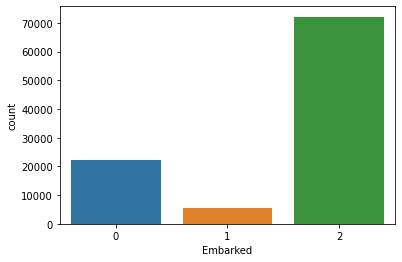

In [34]:
sns.countplot(Embarked_train["Embarked"])
plt.show

In [35]:
smk = SMOTETomek(n_jobs=-1,random_state=0)
X_resample, y_resample = smk.fit_resample(Embarked_train.iloc[:,:-1],Embarked_train.iloc[:,-1])

<function matplotlib.pyplot.show(close=None, block=None)>

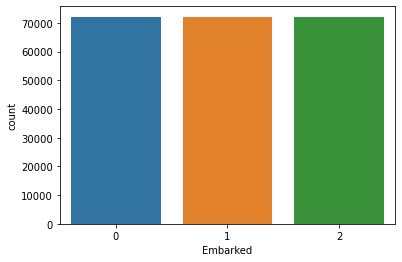

In [36]:
sns.countplot(y_resample)
plt.show

In [37]:
Embarked_test = pd.get_dummies(Embarked_test)
Embarked_test

,Pclass,SibSp,Parch,Sex_female,Sex_male
122,2,0,0,0,1
266,3,0,0,0,1
489,1,0,0,1,0
1017,1,0,0,1,0
2005,1,0,0,1,0
...,...,...,...,...,...
98228,3,0,0,0,1
98577,3,0,1,1,0
98873,1,2,1,1,0
99237,3,0,0,1,0


In [38]:
X_Embarked = X_resample.values
y_Embarked = y_resample.values
X_Embarked_test = Embarked_test.iloc[:,:].values

In [39]:
X_Embarked_train, X_Embarked_valid, y_Embarked_train, y_Embarked_valid = train_test_split(X_Embarked, y_Embarked, random_state=0)

In [40]:
sc = StandardScaler()

In [41]:
X_Embarked_train = sc.fit_transform(X_Embarked_train)
X_Embarked_valid = sc.transform(X_Embarked_valid)
X_Embarked_test  = sc.transform(X_Embarked_test)

In [42]:
lc_Embarked = LazyClassifier()

In [43]:
#lc_Embarked.fit(X_train, X_valid, y_train, y_valid)

In [44]:
xgbc_Embarked = XGBClassifier(n_jobs=-1)
xgbc_Embarked.fit(X_Embarked_train,y_Embarked_train)
print(xgbc_Embarked.score(X_Embarked_train,y_Embarked_train))
print(xgbc_Embarked.score(X_Embarked_valid,y_Embarked_valid))

0.5462599577354584
0.5472608309921633


In [45]:
report = classification_report(y_Embarked_train, xgbc_Embarked.predict(X_Embarked_train),output_dict=True)

In [46]:
report

{'0': {'precision': 0.46131724002701585,
  'recall': 0.3913429194544043,
  'f1-score': 0.42345882705864707,
  'support': 54106},
 '1': {'precision': 0.5429781370258961,
  'recall': 0.5967604905437353,
  'f1-score': 0.5686003642730817,
  'support': 54144},
 '2': {'precision': 0.6182057815657676,
  'recall': 0.6507278814672315,
  'f1-score': 0.6340500693906242,
  'support': 54061},
 'accuracy': 0.5462599577354584,
 'macro avg': {'precision': 0.5408337195395598,
  'recall': 0.5462770971551237,
  'f1-score': 0.5420364202407844,
  'support': 162311},
 'weighted avg': {'precision': 0.5408127705285458,
  'recall': 0.5462599577354584,
  'f1-score': 0.5420171289768619,
  'support': 162311}}

In [47]:
pd.DataFrame(report)

,0,1,2,accuracy,macro avg,weighted avg
precision,0.46,0.54,0.62,0.55,0.54,0.54
recall,0.39,0.60,0.65,0.55,0.55,0.55
f1-score,0.42,0.57,0.63,0.55,0.54,0.54
support,54106.00,54144.00,54061.00,0.55,162311.00,162311.00


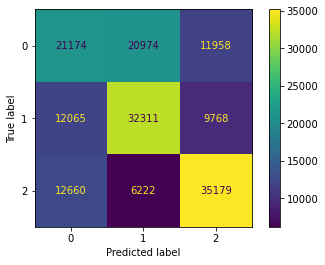

In [48]:
plot_confusion_matrix(xgbc_Embarked, X_Embarked_train, y_Embarked_train)
plt.show()

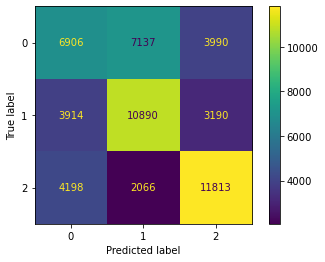

In [49]:
plot_confusion_matrix(xgbc_Embarked, X_Embarked_valid, y_Embarked_valid)
plt.show()

In [50]:
parameters = {
               "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
               "max_depth"        : [3, 4, 5, 6, 8, 10, 12, 15],
               "min_child_weight" : [1, 3, 5, 7],
               "gamma"            : [0.0, 0.1, 0.2 , 0.3, 0.4],
               "colsample_bytree" : [0.3, 0.4, 0.5 , 0.7] 
              }

In [51]:
rs_cv = RandomizedSearchCV(estimator = xgbc_Embarked, param_distributions = parameters,
                                 n_iter=5,n_jobs=-1,cv=5,verbose=3) 

In [52]:
#rs_cv.fit(X_Embarked_train,y_Embarked_train)

In [53]:
#rs_cv.best_params_

In [54]:
#xgbc_Embarked_best = rs_cv.best_estimator_

In [55]:
xgbc_Embarked_best = XGBClassifier(min_child_weight= 5,max_depth= 12,learning_rate= 0.3,gamma= 0.1,colsample_bytree= 0.7)

In [56]:
xgbc_Embarked_best.fit(X_Embarked_train,y_Embarked_train)
print(xgbc_Embarked_best.score(X_Embarked_train,y_Embarked_train))
print(xgbc_Embarked_best.score(X_Embarked_valid,y_Embarked_valid))

0.5457424327371527
0.5475750406624279


In [57]:
null_Embarked_predict = xgbc_Embarked_best.predict(X_Embarked_test)
null_Embarked_predict

array([2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 2, 1, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2,
       0, 1, 1, 0, 1, 2, 0, 0, 2, 2, 0, 1, 2, 2, 0, 2, 2, 2, 0, 1, 2, 2,
       2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 1, 0, 0, 0, 2, 2, 0, 2, 0, 1, 2, 1,
       2, 0, 0, 2, 0, 2, 2, 2, 2, 0, 1, 0, 1, 1, 0, 2, 0, 2, 1, 1, 2, 0,
       1, 2, 0, 1, 2, 1, 0, 2, 1, 2, 0, 2, 2, 0, 2, 1, 1, 2, 1, 2, 2, 2,
       2, 2, 2, 0, 0, 2, 1, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0,
       0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 2, 2, 1, 2, 2, 1,
       0, 1, 2, 1, 1, 0, 0, 0, 1, 2, 1, 2, 1, 1, 2, 1, 0, 2, 0, 2, 2, 0,
       1, 0, 1, 1, 0, 1, 2, 0, 2, 2, 2, 2, 0, 1, 2, 2, 1, 0, 2, 0, 2, 0,
       0, 0, 2, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 1, 2, 1, 2, 1, 1,
       2, 0, 0, 2, 0, 1, 0, 2, 2, 0, 0, 0, 0, 2, 2, 1, 2, 2, 1, 2, 0, 0,
       2, 1, 1, 2, 0, 0, 2, 1])

In [58]:
null_Embarked_predict = enc_LE.inverse_transform(null_Embarked_predict)
null_Embarked_predict

array(['S', 'S', 'Q', 'Q', 'Q', 'Q', 'Q', 'C', 'C', 'C', 'S', 'Q', 'S',
       'S', 'Q', 'S', 'S', 'S', 'C', 'S', 'S', 'S', 'C', 'Q', 'Q', 'C',
       'Q', 'S', 'C', 'C', 'S', 'S', 'C', 'Q', 'S', 'S', 'C', 'S', 'S',
       'S', 'C', 'Q', 'S', 'S', 'S', 'S', 'S', 'S', 'C', 'S', 'C', 'S',
       'C', 'S', 'Q', 'C', 'C', 'C', 'S', 'S', 'C', 'S', 'C', 'Q', 'S',
       'Q', 'S', 'C', 'C', 'S', 'C', 'S', 'S', 'S', 'S', 'C', 'Q', 'C',
       'Q', 'Q', 'C', 'S', 'C', 'S', 'Q', 'Q', 'S', 'C', 'Q', 'S', 'C',
       'Q', 'S', 'Q', 'C', 'S', 'Q', 'S', 'C', 'S', 'S', 'C', 'S', 'Q',
       'Q', 'S', 'Q', 'S', 'S', 'S', 'S', 'S', 'S', 'C', 'C', 'S', 'Q',
       'S', 'C', 'S', 'S', 'C', 'S', 'S', 'S', 'S', 'S', 'C', 'S', 'S',
       'S', 'C', 'C', 'C', 'S', 'S', 'S', 'C', 'S', 'S', 'S', 'S', 'C',
       'C', 'C', 'C', 'S', 'C', 'S', 'S', 'Q', 'S', 'S', 'Q', 'C', 'Q',
       'S', 'Q', 'Q', 'C', 'C', 'C', 'Q', 'S', 'Q', 'S', 'Q', 'Q', 'S',
       'Q', 'C', 'S', 'C', 'S', 'S', 'C', 'Q', 'C', 'Q', 'Q', 'C

In [59]:
Embarked_ds_test = ds_test.filter(['Pclass','Sex','SibSp','Parch','Embarked'], axis=1)

In [60]:
Embarked_ds_test

,Pclass,Sex,SibSp,Parch,Embarked
0,3,male,0,0,S
1,3,female,0,0,S
2,1,female,0,0,C
3,2,male,0,0,S
4,1,female,0,2,C
...,...,...,...,...,...
99995,3,female,0,0,Q
99996,1,male,1,0,S
99997,3,male,0,0,S
99998,1,female,1,2,C


In [61]:
Embarked_test_ds_test = Embarked_ds_test[Embarked_ds_test["Embarked"].isna()]

In [62]:
Embarked_test_ds_test

,Pclass,Sex,SibSp,Parch,Embarked
65,3,male,0,0,NaN
267,1,female,0,0,NaN
1265,2,male,0,0,NaN
1814,1,female,0,2,NaN
1872,3,male,0,0,NaN
...,...,...,...,...,...
97750,2,male,0,0,NaN
98117,1,male,1,2,NaN
99169,3,female,0,0,NaN
99605,1,male,1,2,NaN


In [63]:
Embarked_test_ds_test.drop(columns="Embarked",axis=1,inplace=True)

In [64]:
Embarked_test_ds_test

,Pclass,Sex,SibSp,Parch
65,3,male,0,0
267,1,female,0,0
1265,2,male,0,0
1814,1,female,0,2
1872,3,male,0,0
...,...,...,...,...
97750,2,male,0,0
98117,1,male,1,2
99169,3,female,0,0
99605,1,male,1,2


In [65]:
Embarked_test_ds_test = pd.get_dummies(Embarked_test_ds_test)
Embarked_test_ds_test

,Pclass,SibSp,Parch,Sex_female,Sex_male
65,3,0,0,0,1
267,1,0,0,1,0
1265,2,0,0,0,1
1814,1,0,2,1,0
1872,3,0,0,0,1
...,...,...,...,...,...
97750,2,0,0,0,1
98117,1,1,2,0,1
99169,3,0,0,1,0
99605,1,1,2,0,1


In [66]:
X_Embarked_test_ds_test = Embarked_test_ds_test.iloc[:,:].values

In [67]:
null_Embarked_predict_ds_test = xgbc_Embarked_best.predict(X_Embarked_test_ds_test)
null_Embarked_predict_ds_test

array([2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [68]:
null_Embarked_predict_ds_test = enc_LE.inverse_transform(null_Embarked_predict_ds_test)
null_Embarked_predict_ds_test

array(['S', 'S', 'S', 'S', 'S', 'S', 'S', 'C', 'S', 'S', 'S', 'S', 'S',
       'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S',
       'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S',
       'C', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'C', 'S', 'S',
       'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S',
       'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S',
       'S', 'S', 'S', 'S', 'C', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S',
       'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S',
       'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S',
       'C', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S',
       'S', 'S', 'S', 'S', 'C', 'S', 'S', 'S', 'S', 'C', 'S', 'S', 'S',
       'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S',
       'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S',
       'S', 'S', 'S', 'S', 'S', 'S', 'S', 'C', 'S', 'S', 'S', 'S

### Handling the null values in Age Column

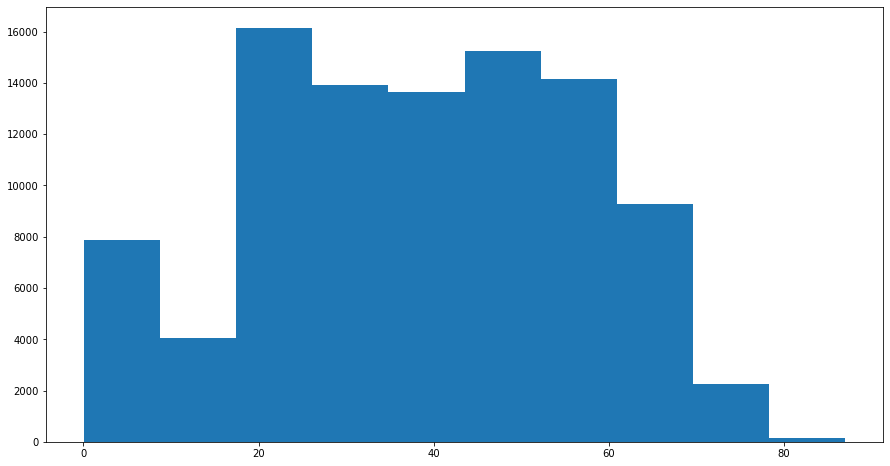

In [69]:
plt.figure(figsize=(15,8))
plt.hist(x=ds_train["Age"])
plt.show()

In [70]:
ds_train["Age"].value_counts()

25.00    2354
23.00    2345
26.00    2320
24.00    2298
27.00    2088
         ... 
69.50       1
87.00       1
74.50       1
78.50       1
80.50       1
Name: Age, Length: 173, dtype: int64

In [71]:
Age = ds_train.filter(['Pclass','Sex','SibSp','Parch','Age'], axis=1)

In [72]:
Age

,Pclass,Sex,SibSp,Parch,Age
0,1,male,2,0,nan
1,3,male,0,0,nan
2,3,male,1,2,0.33
3,3,male,0,0,19.00
4,3,male,0,0,25.00
...,...,...,...,...,...
99995,2,female,0,0,62.00
99996,2,male,0,0,66.00
99997,3,male,0,0,37.00
99998,3,male,0,1,51.00


In [73]:
Age_train = Age.dropna()

In [74]:
Age_train

,Pclass,Sex,SibSp,Parch,Age
2,3,male,1,2,0.33
3,3,male,0,0,19.00
4,3,male,0,0,25.00
5,2,male,0,0,35.00
6,3,male,0,0,7.00
...,...,...,...,...,...
99995,2,female,0,0,62.00
99996,2,male,0,0,66.00
99997,3,male,0,0,37.00
99998,3,male,0,1,51.00


In [75]:
ds_train["Age"].unique()

array([     nan, 3.30e-01, 1.90e+01, 2.50e+01, 3.50e+01, 7.00e+00,
       6.00e+00, 2.70e+01, 6.60e+01, 3.10e+01, 6.00e+01, 3.60e+01,
       5.00e+01, 4.40e+01, 5.70e+01, 5.30e+01, 4.30e+01, 6.10e+01,
       1.70e+01, 3.90e+01, 5.90e+01, 2.30e+01, 2.10e+01, 2.60e+01,
       5.00e+00, 6.70e+01, 5.40e+01, 6.90e+01, 2.20e+01, 6.80e+01,
       7.10e+01, 6.30e+01, 4.70e+01, 4.50e+01, 3.40e+01, 3.00e+00,
       2.80e+01, 3.70e+01, 6.40e+01, 5.80e+01, 5.60e+01, 4.00e+01,
       3.80e+01, 2.00e+01, 8.00e+00, 7.00e+01, 1.10e+01, 4.90e+01,
       5.20e+01, 4.80e+01, 4.10e+01, 3.20e+01, 6.20e+01, 5.50e+01,
       6.50e+01, 4.60e+01, 2.00e+00, 4.20e+01, 2.90e+01, 5.10e+01,
       1.40e+01, 2.40e+01, 3.00e+01, 3.30e+01, 1.80e+01, 7.90e+01,
       1.20e+01, 9.00e+00, 8.30e-01, 1.00e+00, 1.50e+01, 5.00e-01,
       1.00e+01, 7.20e+01, 2.45e+01, 7.70e+01, 7.30e+01, 4.00e+00,
       7.50e-01, 1.60e+01, 8.00e+01, 1.30e+01, 7.40e+01, 2.65e+01,
       5.45e+01, 7.50e+01, 3.65e+01, 7.60e+01, 9.20e-01, 4.25e

In [76]:
Age_test = Age[Age["Age"].isna()]

In [77]:
Age_test

,Pclass,Sex,SibSp,Parch,Age
0,1,male,2,0,nan
1,3,male,0,0,nan
34,2,female,0,0,nan
35,3,male,0,0,nan
36,1,female,0,0,nan
...,...,...,...,...,...
99772,1,male,0,2,nan
99876,3,male,0,0,nan
99971,3,male,0,0,nan
99972,3,male,0,0,nan


In [78]:
Age_train = pd.get_dummies(Age_train)
Age_train

,Pclass,SibSp,Parch,Age,Sex_female,Sex_male
2,3,1,2,0.33,0,1
3,3,0,0,19.00,0,1
4,3,0,0,25.00,0,1
5,2,0,0,35.00,0,1
6,3,0,0,7.00,0,1
...,...,...,...,...,...,...
99995,2,0,0,62.00,1,0
99996,2,0,0,66.00,0,1
99997,3,0,0,37.00,0,1
99998,3,0,1,51.00,0,1


In [79]:
target = Age_train["Age"]
Age_train.drop(columns="Age",axis=1,inplace=True)
Age_train["Age"] = target
Age_train

,Pclass,SibSp,Parch,Sex_female,Sex_male,Age
2,3,1,2,0,1,0.33
3,3,0,0,0,1,19.00
4,3,0,0,0,1,25.00
5,2,0,0,0,1,35.00
6,3,0,0,0,1,7.00
...,...,...,...,...,...,...
99995,2,0,0,1,0,62.00
99996,2,0,0,0,1,66.00
99997,3,0,0,0,1,37.00
99998,3,0,1,0,1,51.00


In [80]:
Age_train["Age"] = np.ceil(Age_train["Age"])

In [81]:
Age_train["Age"] = Age_train["Age"].astype(np.int32)

In [82]:
Age_train

,Pclass,SibSp,Parch,Sex_female,Sex_male,Age
2,3,1,2,0,1,1
3,3,0,0,0,1,19
4,3,0,0,0,1,25
5,2,0,0,0,1,35
6,3,0,0,0,1,7
...,...,...,...,...,...,...
99995,2,0,0,1,0,62
99996,2,0,0,0,1,66
99997,3,0,0,0,1,37
99998,3,0,1,0,1,51


In [83]:
Age_test.dropna(axis=1,inplace=True)
Age_test

,Pclass,Sex,SibSp,Parch
0,1,male,2,0
1,3,male,0,0
34,2,female,0,0
35,3,male,0,0
36,1,female,0,0
...,...,...,...,...
99772,1,male,0,2
99876,3,male,0,0
99971,3,male,0,0
99972,3,male,0,0


In [84]:
Age_test = pd.get_dummies(Age_test)
Age_test

,Pclass,SibSp,Parch,Sex_female,Sex_male
0,1,2,0,0,1
1,3,0,0,0,1
34,2,0,0,1,0
35,3,0,0,0,1
36,1,0,0,1,0
...,...,...,...,...,...
99772,1,0,2,0,1
99876,3,0,0,0,1
99971,3,0,0,0,1
99972,3,0,0,0,1


In [85]:
X_Age = Age_train.iloc[:,:-1].values
y_Age = Age_train.iloc[:,-1].values
X_Age_test = Age_test.iloc[:,:].values

In [86]:
X_Age_train, X_Age_valid, y_Age_train, y_Age_valid = train_test_split(X_Age, y_Age, random_state = 0)

In [87]:
sc = StandardScaler()

In [88]:
X_Age_train = sc.fit_transform(X_Age_train)
X_Age_valid = sc.transform(X_Age_valid)
X_Age_test = sc.transform(X_Age_test)

In [89]:
lc_Age = LazyClassifier()

In [90]:
#lc_Age.fit(X_Age_train, X_Age_valid, y_Age_train, y_Age_valid)

In [91]:
lr_Age = LazyRegressor()

In [92]:
#lr_Age.fit(X_Age_train, X_Age_valid, y_Age_train, y_Age_valid)

In [93]:
xgbr_Age = XGBRegressor()

In [94]:
xgbr_Age.fit(X_Age_train,y_Age_train)
print(xgbr_Age.score(X_Age_train,y_Age_train))
print(xgbr_Age.score(X_Age_valid,y_Age_valid))

0.1658088336572654
0.16060426105000436


In [95]:
null_Age_predict = xgbr_Age.predict(X_Age_test)
null_Age_predict

array([41.476254, 35.93303 , 42.656555, ..., 35.93303 , 35.93303 ,
       35.93303 ], dtype=float32)

In [96]:
Age_ds_test = ds_test.filter(['Pclass','Sex','SibSp','Parch','Age'], axis=1)

In [97]:
Age_ds_test

,Pclass,Sex,SibSp,Parch,Age
0,3,male,0,0,19.00
1,3,female,0,0,53.00
2,1,female,0,0,19.00
3,2,male,0,0,25.00
4,1,female,0,2,17.00
...,...,...,...,...,...
99995,3,female,0,0,27.00
99996,1,male,1,0,59.00
99997,3,male,0,0,47.00
99998,1,female,1,2,49.00


In [98]:
Age_test_ds_test = Age_ds_test[Age_ds_test["Age"].isna()]

In [99]:
Age_test_ds_test

,Pclass,Sex,SibSp,Parch,Age
134,1,female,0,1,nan
216,3,male,0,1,nan
219,3,female,0,0,nan
225,1,male,0,2,nan
238,2,female,1,0,nan
...,...,...,...,...,...
99777,3,female,0,0,nan
99845,2,female,0,0,nan
99861,3,male,1,1,nan
99901,2,female,1,1,nan


In [100]:
Age_test_ds_test.drop(columns="Age",axis=1,inplace=True)

In [101]:
Age_test_ds_test

,Pclass,Sex,SibSp,Parch
134,1,female,0,1
216,3,male,0,1
219,3,female,0,0
225,1,male,0,2
238,2,female,1,0
...,...,...,...,...
99777,3,female,0,0
99845,2,female,0,0
99861,3,male,1,1
99901,2,female,1,1


In [102]:
Age_test_ds_test = pd.get_dummies(Age_test_ds_test)
Age_test_ds_test

,Pclass,SibSp,Parch,Sex_female,Sex_male
134,1,0,1,1,0
216,3,0,1,0,1
219,3,0,0,1,0
225,1,0,2,0,1
238,2,1,0,1,0
...,...,...,...,...,...
99777,3,0,0,1,0
99845,2,0,0,1,0
99861,3,1,1,0,1
99901,2,1,1,1,0


In [103]:
X_Age_test_ds_test = Age_test_ds_test.iloc[:,:].values

In [104]:
null_Age_predict_ds_test = xgbr_Age.predict(X_Age_test_ds_test)
null_Age_predict_ds_test

array([36.725918, 34.772263, 37.77332 , ..., 19.521862, 18.482058,
       29.119389], dtype=float32)

### Handling the null values in Fare Column

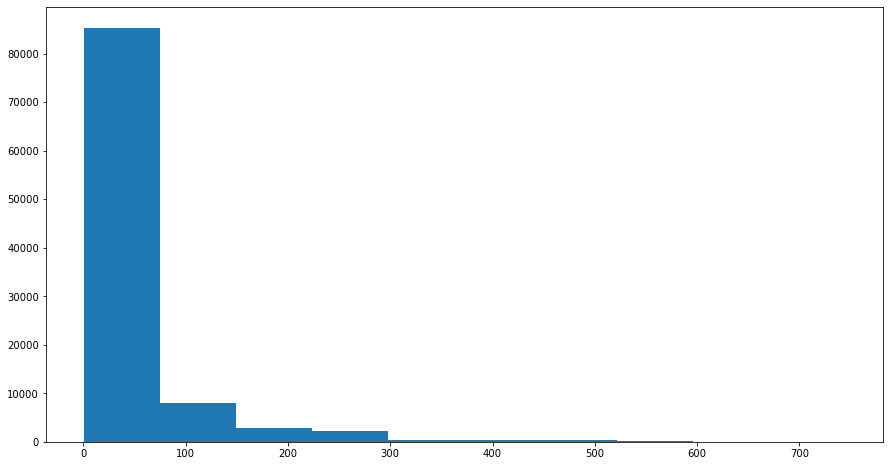

In [105]:
plt.figure(figsize=(15,8))
plt.hist(x=ds_train["Fare"])
plt.show()

In [106]:
ds_train["Fare"].value_counts()

9.27      87
9.85      87
9.79      86
9.20      85
9.45      83
          ..
116.37     1
92.61      1
234.53     1
167.70     1
241.34     1
Name: Fare, Length: 15935, dtype: int64

In [107]:
Fare = ds_train.filter(['Pclass','Sex','SibSp','Parch','Fare'], axis=1)

In [108]:
Fare

,Pclass,Sex,SibSp,Parch,Fare
0,1,male,2,0,27.14
1,3,male,0,0,13.35
2,3,male,1,2,71.29
3,3,male,0,0,13.04
4,3,male,0,0,7.76
...,...,...,...,...,...
99995,2,female,0,0,14.86
99996,2,male,0,0,11.15
99997,3,male,0,0,9.95
99998,3,male,0,1,30.92


In [109]:
Fare_train = Fare.dropna()

In [110]:
Fare_train

,Pclass,Sex,SibSp,Parch,Fare
0,1,male,2,0,27.14
1,3,male,0,0,13.35
2,3,male,1,2,71.29
3,3,male,0,0,13.04
4,3,male,0,0,7.76
...,...,...,...,...,...
99995,2,female,0,0,14.86
99996,2,male,0,0,11.15
99997,3,male,0,0,9.95
99998,3,male,0,1,30.92


In [111]:
Fare_test = Fare[Fare["Fare"].isna()]

In [112]:
Fare_test

,Pclass,Sex,SibSp,Parch,Fare
39,2,female,0,0,nan
1404,1,female,0,0,nan
1909,2,female,0,0,nan
1999,3,female,1,2,nan
3885,1,female,1,2,nan
...,...,...,...,...,...
92227,3,female,0,0,nan
93617,2,female,0,0,nan
93908,2,female,0,0,nan
94656,3,male,0,0,nan


In [113]:
Fare_train = pd.get_dummies(Fare_train)
Fare_train

,Pclass,SibSp,Parch,Fare,Sex_female,Sex_male
0,1,2,0,27.14,0,1
1,3,0,0,13.35,0,1
2,3,1,2,71.29,0,1
3,3,0,0,13.04,0,1
4,3,0,0,7.76,0,1
...,...,...,...,...,...,...
99995,2,0,0,14.86,1,0
99996,2,0,0,11.15,0,1
99997,3,0,0,9.95,0,1
99998,3,0,1,30.92,0,1


In [114]:
target = Fare_train["Fare"]
Fare_train.drop(columns="Fare",axis=1,inplace=True)
Fare_train["Fare"] = target
Fare_train

,Pclass,SibSp,Parch,Sex_female,Sex_male,Fare
0,1,2,0,0,1,27.14
1,3,0,0,0,1,13.35
2,3,1,2,0,1,71.29
3,3,0,0,0,1,13.04
4,3,0,0,0,1,7.76
...,...,...,...,...,...,...
99995,2,0,0,1,0,14.86
99996,2,0,0,0,1,11.15
99997,3,0,0,0,1,9.95
99998,3,0,1,0,1,30.92


In [115]:
Fare_test.dropna(axis=1,inplace=True)
Fare_test

,Pclass,Sex,SibSp,Parch
39,2,female,0,0
1404,1,female,0,0
1909,2,female,0,0
1999,3,female,1,2
3885,1,female,1,2
...,...,...,...,...
92227,3,female,0,0
93617,2,female,0,0
93908,2,female,0,0
94656,3,male,0,0


In [116]:
Fare_test = pd.get_dummies(Fare_test)
Fare_test

,Pclass,SibSp,Parch,Sex_female,Sex_male
39,2,0,0,1,0
1404,1,0,0,1,0
1909,2,0,0,1,0
1999,3,1,2,1,0
3885,1,1,2,1,0
...,...,...,...,...,...
92227,3,0,0,1,0
93617,2,0,0,1,0
93908,2,0,0,1,0
94656,3,0,0,0,1


In [117]:
X_Fare = Fare_train.iloc[:,:-1].values
y_Fare = Fare_train.iloc[:,-1].values
X_Fare_test = Fare_test.iloc[:,:].values

In [118]:
X_Fare_train, X_Fare_valid, y_Fare_train, y_Fare_valid = train_test_split(X_Fare, y_Fare, random_state = 0)

In [119]:
sc = StandardScaler()

In [120]:
X_Fare_train = sc.fit_transform(X_Fare_train)
X_Fare_valid = sc.transform(X_Fare_valid)
X_Fare_test = sc.transform(X_Fare_test)

In [121]:
lr_Fare = LazyRegressor()

In [122]:
#lr_Fare.fit(X_Fare_train, X_Fare_valid, y_Fare_train, y_Fare_valid)

In [123]:
xgbr_Fare = XGBRegressor()

In [124]:
xgbr_Fare.fit(X_Fare_train,y_Fare_train)
print(xgbr_Fare.score(X_Fare_train,y_Fare_train))
print(xgbr_Fare.score(X_Fare_valid,y_Fare_valid))

0.2383593460023894
0.24319328619097258


In [125]:
null_Fare_predict = xgbr_Fare.predict(X_Fare_test)
null_Fare_predict

array([ 24.038837, 107.65275 ,  24.038837,  45.580795,  92.18541 ,
        24.038837,  16.43868 ,  26.835714,  16.43868 ,  29.274616,
        36.735256,  29.260754,  14.488145,  24.038837,  14.488145,
        16.43868 ,  24.038837, 107.65275 ,  37.627903,  29.274616,
        82.397934,  85.00186 ,  19.591269,  24.038837,  14.488145,
        19.591269,  19.591269,  83.39151 ,  19.591269,  14.488145,
        24.038837,  19.591269,  24.038837,  82.954475,  76.942795,
        19.591269,  14.488145, 107.65275 ,  74.19914 ,  29.274616,
        16.43868 ,  14.488145,  14.488145,  19.591269,  26.719227,
        14.488145,  68.17139 , 107.65275 ,  19.591269,  95.98237 ,
        24.038837,  83.43727 , 112.43405 ,  14.488145,  39.804344,
        16.924461,  14.488145,  83.43727 ,  24.038837,  19.591269,
        83.39151 ,  36.789764,  19.591269,  14.488145, 107.65275 ,
        14.488145,  74.19914 ,  45.914585,  82.397934,  83.43727 ,
        92.18541 ,  95.98237 ,  24.038837,  14.488145,  82.397

In [126]:
Fare_ds_test = ds_test.filter(['Pclass','Sex','SibSp','Parch','Fare'], axis=1)

In [127]:
Fare_ds_test

,Pclass,Sex,SibSp,Parch,Fare
0,3,male,0,0,63.01
1,3,female,0,0,5.81
2,1,female,0,0,38.91
3,2,male,0,0,12.93
4,1,female,0,2,26.89
...,...,...,...,...,...
99995,3,female,0,0,10.12
99996,1,male,1,0,68.31
99997,3,male,0,0,10.87
99998,1,female,1,2,29.68


In [128]:
Fare_test_ds_test = Fare_ds_test[Fare_ds_test["Fare"].isna()]

In [129]:
Fare_test_ds_test

,Pclass,Sex,SibSp,Parch,Fare
302,3,male,0,0,nan
715,2,female,0,2,nan
1116,1,female,1,2,nan
1691,1,male,0,0,nan
1919,1,female,0,2,nan
...,...,...,...,...,...
97541,1,female,1,1,nan
97728,3,male,1,0,nan
97935,3,male,1,0,nan
98375,2,female,1,1,nan


In [130]:
Fare_test_ds_test.drop(columns="Fare",axis=1,inplace=True)

In [131]:
Fare_test_ds_test

,Pclass,Sex,SibSp,Parch
302,3,male,0,0
715,2,female,0,2
1116,1,female,1,2
1691,1,male,0,0
1919,1,female,0,2
...,...,...,...,...
97541,1,female,1,1
97728,3,male,1,0
97935,3,male,1,0
98375,2,female,1,1


In [132]:
Fare_test_ds_test = pd.get_dummies(Fare_test_ds_test)
Fare_test_ds_test

,Pclass,SibSp,Parch,Sex_female,Sex_male
302,3,0,0,0,1
715,2,0,2,1,0
1116,1,1,2,1,0
1691,1,0,0,0,1
1919,1,0,2,1,0
...,...,...,...,...,...
97541,1,1,1,1,0
97728,3,1,0,0,1
97935,3,1,0,0,1
98375,2,1,1,1,0


In [133]:
X_Fare_test_ds_test = Fare_test_ds_test.iloc[:,:].values

In [134]:
null_Fare_predict_ds_test = xgbr_Fare.predict(X_Fare_test_ds_test)
null_Fare_predict_ds_test

array([14.488145, 29.260754, 45.580795, 14.488145, 29.260754, 31.63146 ,
       14.488145, 14.488145, 36.735256, 14.488145, 14.488145, 16.43868 ,
       31.63146 , 14.488145, 31.63146 , 31.63146 , 14.488145, 20.374628,
       37.627903, 31.63146 , 14.488145, 14.488145, 14.488145, 31.63146 ,
       14.488145, 26.719227, 31.63146 , 31.63146 , 14.488145, 16.43868 ,
       31.63146 , 45.914585, 45.914585, 29.260754, 33.32368 , 36.735256,
       14.488145, 14.488145, 64.55621 , 31.63146 , 37.627903, 16.43868 ,
       45.580795, 36.735256, 31.63146 , 27.718388, 14.488145, 14.488145,
       14.488145, 14.488145, 26.528698, 14.488145, 14.488145, 27.718388,
       37.627903, 20.372746, 45.580795, 16.43868 , 14.488145, 22.049376,
       14.488145, 14.488145, 31.63146 , 37.627903, 45.580795, 33.32368 ,
       14.488145, 37.627903, 16.43868 , 16.43868 , 45.914585, 14.488145,
       16.43868 , 14.488145, 37.627903, 16.924461, 14.488145, 14.488145,
       14.488145, 14.488145, 45.580795, 14.488145, 

# Filling the null values

### Training dataset

In [135]:
ds_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,male,nan,2,0,27.14,S,1
1,3,male,nan,0,0,13.35,S,0
2,3,male,0.33,1,2,71.29,S,0
3,3,male,19.00,0,0,13.04,S,0
4,3,male,25.00,0,0,7.76,S,1
...,...,...,...,...,...,...,...,...
99995,2,female,62.00,0,0,14.86,C,1
99996,2,male,66.00,0,0,11.15,S,0
99997,3,male,37.00,0,0,9.95,S,0
99998,3,male,51.00,0,1,30.92,S,0


In [136]:
null_Embarked = ds_train["Embarked"].isna()
ds_train.loc[null_Embarked, "Embarked"] = null_Embarked_predict

In [137]:
null_Age = ds_train["Age"].isna()
ds_train.loc[null_Age, "Age"] = null_Age_predict

In [138]:
null_Fare = ds_train["Fare"].isna()
ds_train.loc[null_Fare, "Fare"] = null_Fare_predict

In [139]:
ds_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,male,41.48,2,0,27.14,S,1
1,3,male,35.93,0,0,13.35,S,0
2,3,male,0.33,1,2,71.29,S,0
3,3,male,19.00,0,0,13.04,S,0
4,3,male,25.00,0,0,7.76,S,1
...,...,...,...,...,...,...,...,...
99995,2,female,62.00,0,0,14.86,C,1
99996,2,male,66.00,0,0,11.15,S,0
99997,3,male,37.00,0,0,9.95,S,0
99998,3,male,51.00,0,1,30.92,S,0


In [140]:
ds_train = pd.get_dummies(ds_train)
ds_train

,Pclass,Age,SibSp,Parch,Fare,Survived,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,41.48,2,0,27.14,1,0,1,0,0,1
1,3,35.93,0,0,13.35,0,0,1,0,0,1
2,3,0.33,1,2,71.29,0,0,1,0,0,1
3,3,19.00,0,0,13.04,0,0,1,0,0,1
4,3,25.00,0,0,7.76,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
99995,2,62.00,0,0,14.86,1,1,0,1,0,0
99996,2,66.00,0,0,11.15,0,0,1,0,0,1
99997,3,37.00,0,0,9.95,0,0,1,0,0,1
99998,3,51.00,0,1,30.92,0,0,1,0,0,1


In [141]:
target = ds_train["Survived"]
ds_train.drop(columns="Survived", inplace=True, axis=1)
ds_train["Survived"] = target
ds_train

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Survived
0,1,41.48,2,0,27.14,0,1,0,0,1,1
1,3,35.93,0,0,13.35,0,1,0,0,1,0
2,3,0.33,1,2,71.29,0,1,0,0,1,0
3,3,19.00,0,0,13.04,0,1,0,0,1,0
4,3,25.00,0,0,7.76,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
99995,2,62.00,0,0,14.86,1,0,1,0,0,1
99996,2,66.00,0,0,11.15,0,1,0,0,1,0
99997,3,37.00,0,0,9.95,0,1,0,0,1,0
99998,3,51.00,0,1,30.92,0,1,0,0,1,0


### Testing dataset

In [142]:
ds_test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,19.00,0,0,63.01,S
1,3,female,53.00,0,0,5.81,S
2,1,female,19.00,0,0,38.91,C
3,2,male,25.00,0,0,12.93,S
4,1,female,17.00,0,2,26.89,C
...,...,...,...,...,...,...,...
99995,3,female,27.00,0,0,10.12,Q
99996,1,male,59.00,1,0,68.31,S
99997,3,male,47.00,0,0,10.87,S
99998,1,female,49.00,1,2,29.68,C


In [143]:
null_Embarked_ds_test = ds_test["Embarked"].isna()
ds_test.loc[null_Embarked_ds_test, "Embarked"] = null_Embarked_predict_ds_test

In [144]:
null_Age_ds_test = ds_test["Age"].isna()
ds_test.loc[null_Age_ds_test, "Age"] = null_Age_predict_ds_test

In [145]:
null_Fare_ds_test = ds_test["Fare"].isna()
ds_test.loc[null_Fare_ds_test, "Fare"] = null_Fare_predict_ds_test

In [146]:
ds_test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,19.00,0,0,63.01,S
1,3,female,53.00,0,0,5.81,S
2,1,female,19.00,0,0,38.91,C
3,2,male,25.00,0,0,12.93,S
4,1,female,17.00,0,2,26.89,C
...,...,...,...,...,...,...,...
99995,3,female,27.00,0,0,10.12,Q
99996,1,male,59.00,1,0,68.31,S
99997,3,male,47.00,0,0,10.87,S
99998,1,female,49.00,1,2,29.68,C


In [147]:
ds_test = pd.get_dummies(ds_test)
ds_test

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,19.00,0,0,63.01,0,1,0,0,1
1,3,53.00,0,0,5.81,1,0,0,0,1
2,1,19.00,0,0,38.91,1,0,1,0,0
3,2,25.00,0,0,12.93,0,1,0,0,1
4,1,17.00,0,2,26.89,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
99995,3,27.00,0,0,10.12,1,0,0,1,0
99996,1,59.00,1,0,68.31,0,1,0,0,1
99997,3,47.00,0,0,10.87,0,1,0,0,1
99998,1,49.00,1,2,29.68,1,0,1,0,0


In [163]:
X = ds_train.iloc[:,:-1].values
y = ds_train.iloc[:,-1].values
X_test = ds_test.iloc[:,:].values

In [164]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0)

In [165]:
sc = StandardScaler()

In [166]:
X_train = sc.fit_transform(X_train)
X_valid = sc.transform(X_valid)
X_test = sc.transform(X_test)

In [152]:
lc = LazyClassifier()

In [153]:
#lc.fit(X_train, X_valid, y_train, y_valid)

In [154]:
xgbc = XGBClassifier()

In [155]:
xgbc.fit(X_train,y_train)
print(xgbc.score(X_train,y_train))
print(xgbc.score(X_valid,y_valid))

0.7943733333333334
0.76736


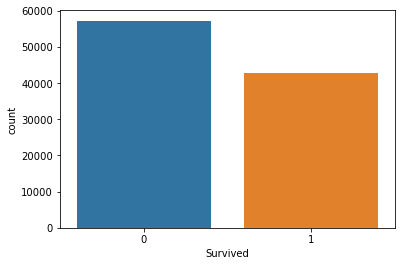

In [156]:
sns.countplot(ds_train["Survived"])
plt.show()

In [157]:
parameters = {
               "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
               "max_depth"        : [3, 4, 5, 6, 8, 10, 12, 15],
               "min_child_weight" : [1, 3, 5, 7],
               "gamma"            : [0.0, 0.1, 0.2 , 0.3, 0.4],
               "colsample_bytree" : [0.3, 0.4, 0.5 , 0.7] 
              }

In [158]:
rs_cv_train = RandomizedSearchCV(estimator = xgbc, param_distributions = parameters,
                                 n_iter=5,n_jobs=-1,cv=5,verbose=3) 

In [159]:
#rs_cv_train.fit(X_train,y_train)

In [160]:
#rs_cv_train.best_params_

In [161]:
xgbc_best = XGBClassifier(min_child_weight = 5, max_depth = 10, learning_rate = 0.2, gamma = 0.0, colsample_bytree = 0.7)

In [162]:
xgbc_best.fit(X_train,y_train)
print(xgbc_best.score(X_train,y_train))
print(xgbc_best.score(X_valid,y_valid))

0.8055866666666667
0.76432


In [167]:
y_predict = xgbc_best.predict(X_test)
y_predict

array([0, 1, 1, ..., 0, 1, 1], dtype=int64)

In [168]:
len(y_predict)

100000

In [181]:
Survived = pd.DataFrame(y_predict,columns=["Survived"])

In [182]:
Survived

,Survived
0,0
1,1
2,1
3,0
4,0
...,...
99995,1
99996,0
99997,0
99998,1


In [183]:
ds_test_PassengerId = pd.read_csv("test.csv")

In [184]:
PassengerId = ds_test_PassengerId.filter(["PassengerId"],axis=1)
PassengerId

,PassengerId
0,100000
1,100001
2,100002
3,100003
4,100004
...,...
99995,199995
99996,199996
99997,199997
99998,199998


In [185]:
predicted =  pd.concat([PassengerId,Survived],axis=1)

In [186]:
predicted

,PassengerId,Survived
0,100000,0
1,100001,1
2,100002,1
3,100003,0
4,100004,0
...,...,...
99995,199995,1
99996,199996,0
99997,199997,0
99998,199998,1


In [188]:
#predicted.to_csv("predicted.csv")